In [44]:
import os
import sys
# sys.path.insert(0,'/code/')

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import roc_curve, auc
import torchvision.transforms as T
from torchvision.datasets import ImageNet, CIFAR100, CIFAR10, STL10, ImageFolder
import pandas as pd
from torchvision.utils import save_image

import multiprocessing as mp
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score

from datasets.dataset import ImageToHash_Attack

from datasets.imagenette import ImageNette
from metrics.hamming_distance import hamming_distance
from adv3_robustness_check import get_rotation_angles, get_translation_tuples, get_rotation_angles_positive
from utils.transforms import Rotate, Translate, ChangeSaturation, ChangeHue, ChangeContrast, ChangeBrightness, \
    JpegCompression, HorizontalFlipping, BlackBorder, CenterCrop, VerticalFlipping
from scipy.interpolate import griddata

sns.set_style("ticks", {'axes.grid': True})

In [45]:
DATASET = 'coco_val'
TARGET = 'photodna_nn_robust_aug_new_collision_1'
PLOT_DIR = f'robustness_by_auc/{DATASET}_{TARGET}_3000'
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)
MAX_ROT_ANGLE = 64
ROT_LOG_BASE = 2
ROT_STEPS = 7
MAX_TRANS = 64
TRANS_LOG_BASE = 2
TRANS_STEPS = 7

HASH_DIR = f'logs/{DATASET}_{TARGET}'

In [46]:
def l1_distance(tensor1, tensor2):
    loss = torch.nn.L1Loss(reduction='sum')
    l1 = []
    for i in range(tensor1.shape[0]):
        l1.append(loss(tensor1[i],tensor2[i]).item())
    return l1

def l1_distance_pairwise(tensor1, tensor2, batch_size=200, use_gpu=True):
    if use_gpu:
        tensor1, tensor2 = tensor1.cuda(), tensor2.cuda()

    num_items_1 = tensor1.size(0)
    num_items_2 = tensor2.size(0)
    l1_matrix = torch.zeros((num_items_1, num_items_2), device='cuda' if use_gpu else 'cpu')

    # Process in batches
    for i in range(0, num_items_1, batch_size):
        end_i = i + batch_size
        tensor1_batch = tensor1[i:end_i]

        for j in range(0, num_items_2, batch_size):
            end_j = j + batch_size
            tensor2_batch = tensor2[j:end_j]

            # Expand and compute distances
            tensor1_expanded = tensor1_batch.unsqueeze(1)
            tensor2_expanded = tensor2_batch.unsqueeze(0)
            diff = torch.abs(tensor1_expanded - tensor2_expanded)
            l1_distances_batch = diff.sum(2)

            # Assign computed distances to the appropriate submatrix
            l1_matrix[i:end_i, j:end_j] = l1_distances_batch

    return l1_matrix.cpu()


def calculate_roc_auc(l1_matrix, threshold_range = (1600, 3000), num_thresholds=100, steepness=0.01, batch_size=200):
    l1_matrix = torch.tensor(l1_matrix, device='cuda')  # Move the matrix to GPU
    n = l1_matrix.size(0)

    # Initialize storage for all probabilities and labels
    all_probabilities = []
    all_labels = []

    # Process the full matrix in batches
    for i in range(0, n, batch_size):
        end_i = min(i + batch_size, n)
        batch = l1_matrix[i:end_i, i:end_i]
        should_match = torch.eye(batch.size(0), device='cuda', dtype=torch.bool)

        # Process each threshold
        thresholds = np.linspace(threshold_range[0], threshold_range[1], num=num_thresholds)
        for threshold in thresholds:
            # Convert distances to probabilities
            probabilities = 1 / (1 + torch.exp(-steepness * (threshold - batch)))

            # Store probabilities and labels
            all_probabilities.append(probabilities.flatten())
            all_labels.append(should_match.flatten())

    # Concatenate results
    all_probabilities = torch.cat(all_probabilities).cpu().numpy()
    all_labels = torch.cat(all_labels).cpu().numpy()
    

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
    roc_auc = auc(fpr, tpr)
    # print("ROC_AUC:", roc_auc)

    return fpr, tpr, thresholds, roc_auc

def get_hashes_from_csv(file_path):
    df = pd.read_csv(file_path)
    df['hash_bin'] = df['hash_bin'].apply(lambda x: x.strip('[]').split() if 'nn' in TARGET else x.split())
    df['hash_bin'] = df['hash_bin'].apply(lambda x: [int(i) for i in x])
    bin_hashes = np.array(df['hash_bin'].tolist()).astype(int)
    
    return bin_hashes


def get_augmented_hashes_and_l1_dist(filenames, augment_values, original_hashes, return_bin_hashes=False, num_processes=2, pairwise = True):
    return_hash_dict = {}
    return_l1_dict = {}

    # with tqdm(total=len(filenames)) as pbar:
    with mp.Pool(num_processes) as pool:
        for i, bin_hashes in tqdm(enumerate(pool.imap(get_hashes_from_csv, filenames))):
            return_hash_dict[augment_values[i]] = bin_hashes
            if pairwise == False:
                # Only calculate the l1 between same index
                return_l1_dict[augment_values[i]] = np.array(l1_distance(torch.tensor(bin_hashes), original_hashes))
            else:
                return_l1_dict[augment_values[i]] = np.array(l1_distance_pairwise(torch.tensor(bin_hashes), original_hashes))


    if return_bin_hashes:
        return return_hash_dict, return_l1_dict

    return return_l1_dict


def print_mean_and_std_for_keys(given_dict):
    for key in given_dict.keys():
        print(f'Mean L1 Distance for {key}: {given_dict[key].mean()}')
        print(f'Standard Deviation L1 Distance for {key}: {given_dict[key].std()}')
        


In [47]:
bin_hashes_orig = torch.tensor(get_hashes_from_csv(os.path.join(HASH_DIR, f'{DATASET}_original.csv')))

# L_inf Robustness

In [48]:
# epsilons = [0.0039, 0.0078, 0.0156, 0.0312]
# linf_hamming = get_augmented_hashes_and_l1_dist(
#     [os.path.join(HASH_DIR, 'linf_epsilon', f'{DATASET}_linf_epsilon_{epsilon}.csv') for epsilon in epsilons],
#     epsilons,
#     bin_hashes_orig,
#     num_processes=4,
#     pairwise=True
# )

In [49]:
# keys = []
# auc_values = []
# for key, value in tqdm(linf_hamming.items()):
#     _, _, _, roc_auc = calculate_roc_auc(value)
#     keys.append(key)
#     auc_values.append(roc_auc)

In [50]:
# # Print angles row
# print("Epsilon:   ", end='')
# for key in keys:
#     print(f"{key:<10}", end='')
# print()  # New line for AUC values
# 
# # Print ROC AUC values row
# print("ROC AUC: ", end='')
# for value in auc_values:
#     print(f"{value:<10.4f}", end='')
# print()  # New line at the end
# 
# # Open a file and append the data
# with open(f'{PLOT_DIR}/{DATASET}.txt', 'a') as file:
#     # Print angles row to the file
#     file.write("Epsilon:  ")
#     for key in keys:
#         file.write(f"{key:<10}")
#     file.write("\n")  # New line for AUC values
# 
#     # Print ROC AUC values row to the file
#     file.write("ROC AUC: ")
#     for value in auc_values:
#         file.write(f"{value:<10.4f}")
#     file.write("\n")  # New line at the end
#     file.write("\n")

# Rotation Robustness

In [51]:
# get the rotation angles
angles = get_rotation_angles_positive(MAX_ROT_ANGLE, ROT_LOG_BASE, ROT_STEPS)

In [52]:
distance = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'rotation', f'{DATASET}_rotation_{angle}.csv') for angle in angles],
    angles,
    bin_hashes_orig,
    num_processes=15,
    pairwise=True
)

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

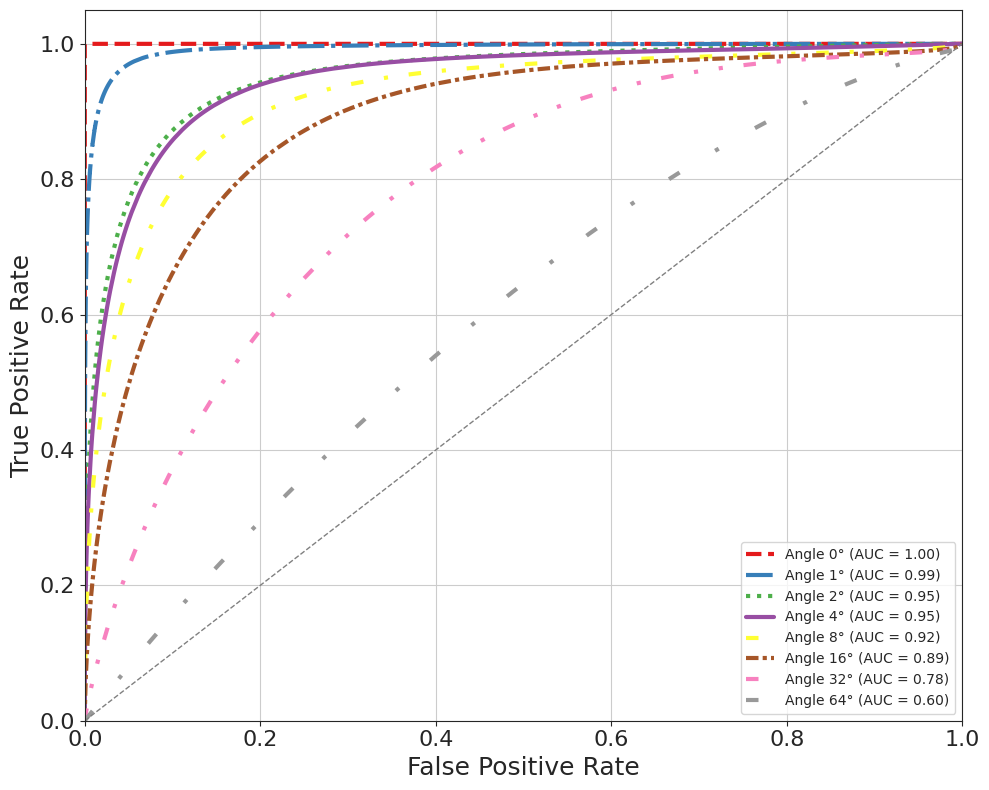

In [53]:
Trans = 'Angle'

keys = []
auc_values = []
plt.figure(figsize=(10, 8))
line_styles = ['--', '-.', ':', '-', (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1)), (0, (3, 5, 1, 5, 1, 5)), (0, (3, 10, 1, 10))]
colors = plt.cm.Set1(np.linspace(0, 1, len(angles)))

for idx, (key, value) in enumerate(tqdm(distance.items())):
    fpr, tpr, thresholds, roc_auc = calculate_roc_auc(value)
    keys.append(key)
    auc_values.append(roc_auc)
    style = line_styles[idx % len(line_styles)] 
    plt.plot(fpr, tpr, color=colors[idx], lw=3, linestyle=style, label=f'{Trans} {key}° (AUC = {roc_auc:.2f})')

# Plot formatting
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Line of no skill
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.legend(loc="lower right")
plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_{Trans}.pdf', bbox_inches='tight')  # Save the figure as a PNG file with tight bounding box


In [54]:
# Print angles row
print("Angle:   ", end='')
for key in keys:
    print(f"{key:<10}", end='')
print()  # New line for AUC values

# Print ROC AUC values row
print("ROC AUC: ", end='')
for value in auc_values:
    print(f"{value:<10.4f}", end='')
print()  # New line at the end

# Open a file and append the data
with open(f'{PLOT_DIR}/{DATASET}.txt', 'a') as file:
    # Print angles row to the file
    file.write("Angle:  ")
    for key in keys:
        file.write(f"{key:<10}")
    file.write("\n")  # New line for AUC values

    # Print ROC AUC values row to the file
    file.write("ROC AUC: ")
    for value in auc_values:
        file.write(f"{value:<10.4f}")
    file.write("\n")  # New line at the end
    file.write("\n")

Angle:   0         1         2         4         8         16        32        64        
ROC AUC: 1.0000    0.9926    0.9513    0.9463    0.9202    0.8854    0.7768    0.5994    


# Hue Robustness

In [55]:
hues = list(range(-180, 180, 30))
distance = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'hue', f'{DATASET}_hue_{hue}.csv') for hue in hues],
    hues,
    bin_hashes_orig,
    num_processes=12,
    pairwise=True
)

0it [00:00, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

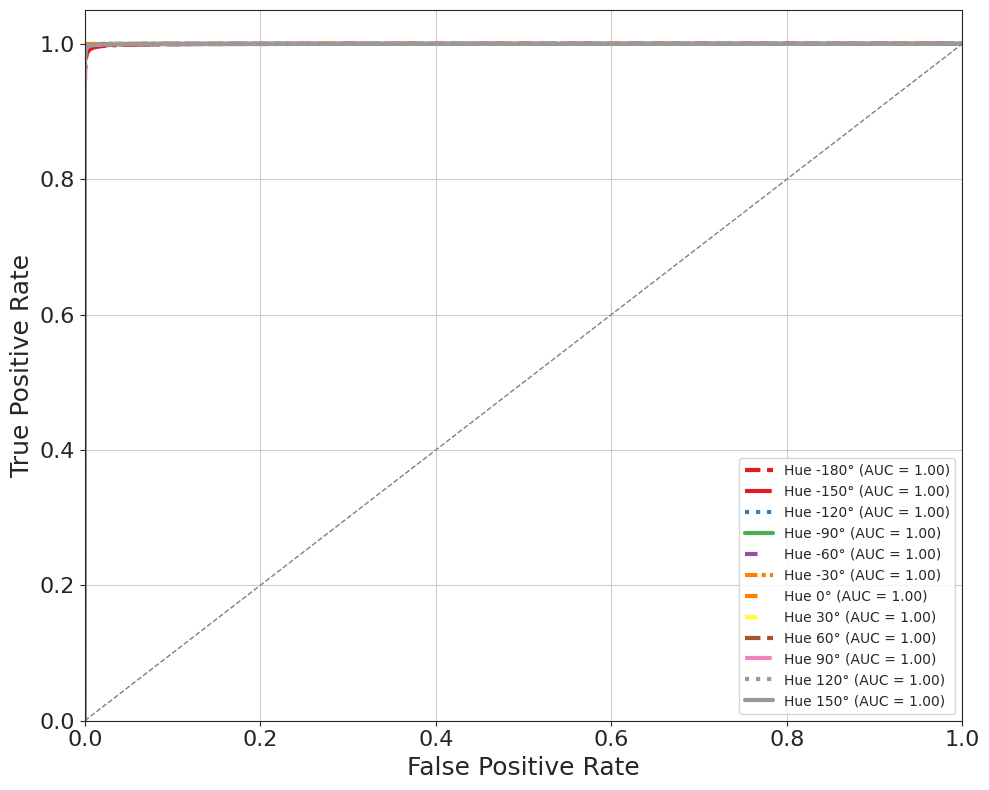

In [56]:
Trans = 'Hue'

keys = []
auc_values = []
plt.figure(figsize=(10, 8))
line_styles = ['--', '-.', ':', '-', (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1)), (0, (3, 5, 1, 5, 1, 5)), (0, (3, 10, 1, 10))]
colors = plt.cm.Set1(np.linspace(0, 1, len(hues)))

for idx, (key, value) in enumerate(tqdm(distance.items())):
    fpr, tpr, thresholds, roc_auc = calculate_roc_auc(value)
    keys.append(key)
    auc_values.append(roc_auc)
    style = line_styles[idx % len(line_styles)] 
    color = colors[idx % len(colors)]
    plt.plot(fpr, tpr, color=color, lw=3, linestyle=style, label=f'{Trans} {key}° (AUC = {roc_auc:.2f})')

# Plot formatting
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Line of no skill
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.legend(loc="lower right")
plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_{Trans}.pdf', bbox_inches='tight')  # Save the figure as a PNG file with tight bounding box


In [57]:
# Print angles row
print("Hue:   ", end='')
for key in keys:
    print(f"{key:<10}", end='')
print()  # New line for AUC values

# Print ROC AUC values row
print("ROC AUC: ", end='')
for value in auc_values:
    print(f"{value:<10.4f}", end='')
print()  # N

# Open a file and append the data
with open(f'{PLOT_DIR}/{DATASET}.txt', 'a') as file:
    # Print angles row to the file
    file.write("Hue:  ")
    for key in keys:
        file.write(f"{key:<10}")
    file.write("\n")  # New line for AUC values

    # Print ROC AUC values row to the file
    file.write("ROC AUC: ")
    for value in auc_values:
        file.write(f"{value:<10.4f}")
    file.write("\n")  # New line at the end
    file.write("\n")

Hue:   -180      -150      -120      -90       -60       -30       0         30        60        90        120       150       
ROC AUC: 0.9998    0.9997    0.9998    1.0000    1.0000    1.0000    1.0000    1.0000    0.9999    0.9999    0.9999    0.9999    


# Brightness Robustness

In [58]:
brightness_values = list(np.linspace(0, 2, 9, endpoint=True))
distance = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'brightness', f'{DATASET}_brightness_{int(brightness)}.csv' if 'nn' not in TARGET else f'{DATASET}_brightness_{brightness}.csv') for brightness in brightness_values],
    brightness_values,
    bin_hashes_orig,
    num_processes=9,
    pairwise=True
)

0it [00:00, ?it/s]

In [59]:
Trans = 'Brightness'

keys = []
auc_values = []
plt.figure(figsize=(10, 8))
line_styles = ['--', '-.', ':', '-', (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1)), (0, (3, 5, 1, 5, 1, 5)), (0, (3, 10, 1, 10))]
colors = plt.cm.Set1(np.linspace(0, 1, len(brightness_values)))

for idx, (key, value) in enumerate(tqdm(distance.items())):
    fpr, tpr, thresholds, roc_auc = calculate_roc_auc(value)
    keys.append(key)
    auc_values.append(roc_auc)
    style = line_styles[idx % len(line_styles)] 
    color = colors[idx % len(colors)]
    plt.plot(fpr, tpr, color=color, lw=3, linestyle=style, label=f'{Trans} {key}° (AUC = {roc_auc:.2f})')

# Plot formatting
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Line of no skill
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.legend(loc="lower right")
plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_{Trans}.pdf', bbox_inches='tight')  # Save the figure as a PNG file with tight bounding box
plt.close()  # Close the plot to free up memory

  0%|          | 0/9 [00:00<?, ?it/s]

In [60]:
# Print angles row
print("Brightness:   ", end='')
for key in keys:
    print(f"{key:<10}", end='')
print()  # New line for AUC values

# Print ROC AUC values row
print("ROC AUC: ", end='')
for value in auc_values:
    print(f"{value:<10.4f}", end='')
print()  # N

# Open a file and append the data
with open(f'{PLOT_DIR}/{DATASET}.txt', 'a') as file:
    # Print angles row to the file
    file.write("Brightness:  ")
    for key in keys:
        file.write(f"{key:<10}")
    file.write("\n")  # New line for AUC values

    # Print ROC AUC values row to the file
    file.write("ROC AUC: ")
    for value in auc_values:
        file.write(f"{value:<10.4f}")
    file.write("\n")  # New line at the end
    file.write("\n")

Brightness:   0.0       0.25      0.5       0.75      1.0       1.25      1.5       1.75      2.0       
ROC AUC: 0.5000    1.0000    1.0000    1.0000    1.0000    1.0000    0.9996    0.9975    0.9929    


# Contrast Robustness

In [61]:
contrast_values = list(np.linspace(0, 2, 9, endpoint=True))
distance = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'contrast', f'{DATASET}_contrast_{int(contrast)}.csv' if 'nn' not in TARGET else f'{DATASET}_contrast_{contrast}.csv') for contrast in contrast_values],
    contrast_values,
    bin_hashes_orig,
    num_processes=9,
    pairwise=True
)

0it [00:00, ?it/s]

In [62]:
Trans = 'Contrast'

keys = []
auc_values = []
plt.figure(figsize=(10, 8))
line_styles = ['--', '-.', ':', '-', (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1)), (0, (3, 5, 1, 5, 1, 5)), (0, (3, 10, 1, 10))]
colors = plt.cm.Set1(np.linspace(0, 1, len(contrast_values)))

for idx, (key, value) in enumerate(tqdm(distance.items())):
    fpr, tpr, thresholds, roc_auc = calculate_roc_auc(value)
    keys.append(key)
    auc_values.append(roc_auc)
    style = line_styles[idx % len(line_styles)] 
    color = colors[idx % len(colors)]
    plt.plot(fpr, tpr, color=color, lw=3, linestyle=style, label=f'{Trans} {key}° (AUC = {roc_auc:.2f})')

# Plot formatting
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Line of no skill
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.legend(loc="lower right")
plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_{Trans}.pdf', bbox_inches='tight')  # Save the figure as a PNG file with tight bounding box
plt.close()  # Close the plot to free up memory

  0%|          | 0/9 [00:00<?, ?it/s]

In [63]:
# Print angles row
print("Contrast:   ", end='')
for key in keys:
    print(f"{key:<10}", end='')
print()  # New line for AUC values

# Print ROC AUC values row
print("ROC AUC: ", end='')
for value in auc_values:
    print(f"{value:<10.4f}", end='')
print()  # N

# Open a file and append the data
with open(f'{PLOT_DIR}/{DATASET}.txt', 'a') as file:
    # Print angles row to the file
    file.write("Contrast:  ")
    for key in keys:
        file.write(f"{key:<10}")
    file.write("\n")  # New line for AUC values

    # Print ROC AUC values row to the file
    file.write("ROC AUC: ")
    for value in auc_values:
        file.write(f"{value:<10.4f}")
    file.write("\n")  # New line at the end
    file.write("\n")

Contrast:   0.0       0.25      0.5       0.75      1.0       1.25      1.5       1.75      2.0       
ROC AUC: 0.5039    0.9096    0.9585    0.9824    1.0000    0.9952    0.9897    0.9852    0.9809    


# Saturation Robustness

In [64]:
saturation_values = list(np.linspace(0, 2, 9, endpoint=True))
distance = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'saturation', f'{DATASET}_saturation_{int(saturation)}.csv' if 'nn' not in TARGET else f'{DATASET}_saturation_{saturation}.csv') for saturation in saturation_values],
    saturation_values,
    bin_hashes_orig,
    num_processes=9,
    pairwise=True
)

0it [00:00, ?it/s]

In [65]:
Trans = 'Saturation'

keys = []
auc_values = []
plt.figure(figsize=(10, 8))
line_styles = ['--', '-.', ':', '-', (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1)), (0, (3, 5, 1, 5, 1, 5)), (0, (3, 10, 1, 10))]
colors = plt.cm.Set1(np.linspace(0, 1, len(saturation_values)))

for idx, (key, value) in enumerate(tqdm(distance.items())):
    fpr, tpr, thresholds, roc_auc = calculate_roc_auc(value)
    keys.append(key)
    auc_values.append(roc_auc)
    style = line_styles[idx % len(line_styles)] 
    color = colors[idx % len(colors)]
    plt.plot(fpr, tpr, color=color, lw=3, linestyle=style, label=f'{Trans} {key}° (AUC = {roc_auc:.2f})')

# Plot formatting
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Line of no skill
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.legend(loc="lower right")
plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_{Trans}.pdf', bbox_inches='tight')  # Save the figure as a PNG file with tight bounding box
plt.close()  # Close the plot to free up memory

  0%|          | 0/9 [00:00<?, ?it/s]

In [66]:
# Print angles row
print("Saturation:   ", end='')
for key in keys:
    print(f"{key:<10}", end='')
print()  # New line for AUC values

# Print ROC AUC values row
print("ROC AUC: ", end='')
for value in auc_values:
    print(f"{value:<10.4f}", end='')
print()  # N


# Open a file and append the data
with open(f'{PLOT_DIR}/{DATASET}.txt', 'a') as file:
    # Print angles row to the file
    file.write("Saturation:  ")
    for key in keys:
        file.write(f"{key:<10}")
    file.write("\n")  # New line for AUC values

    # Print ROC AUC values row to the file
    file.write("ROC AUC: ")
    for value in auc_values:
        file.write(f"{value:<10.4f}")
    file.write("\n")  # New line at the end
    file.write("\n")

Saturation:   0.0       0.25      0.5       0.75      1.0       1.25      1.5       1.75      2.0       
ROC AUC: 1.0000    1.0000    1.0000    1.0000    1.0000    1.0000    1.0000    1.0000    1.0000    


# Compression Robustness

In [67]:
compression_values = [100] + list(
    (100 - np.ceil(np.logspace(0, np.log(100) / np.log(1.5), 10, endpoint=True, base=1.5))).clip(0, 100)
)

distance = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'compression', f'{DATASET}_compression_{int(compression)}.csv' if 'nn' not in TARGET else f'{DATASET}_compression_{compression}.csv') for compression in compression_values],
    compression_values,
    bin_hashes_orig,
    num_processes=11,
    pairwise=True
)


0it [00:00, ?it/s]

In [68]:
Trans = 'Compression'

keys = []
auc_values = []
plt.figure(figsize=(10, 8))
line_styles = ['--', '-.', ':', '-', (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1)), (0, (3, 5, 1, 5, 1, 5)), (0, (3, 10, 1, 10))]
colors = plt.cm.Set1(np.linspace(0, 1, len(compression_values)))

for idx, (key, value) in enumerate(tqdm(distance.items())):
    fpr, tpr, thresholds, roc_auc = calculate_roc_auc(value)
    keys.append(key)
    auc_values.append(roc_auc)
    style = line_styles[idx % len(line_styles)] 
    color = colors[idx % len(colors)]
    plt.plot(fpr, tpr, color=color, lw=3, linestyle=style, label=f'{Trans} {key}° (AUC = {roc_auc:.2f})')

# Plot formatting
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Line of no skill
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.legend(loc="lower right")
plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_{Trans}.pdf', bbox_inches='tight')  # Save the figure as a PNG file with tight bounding box
plt.close()  # Close the plot to free up memory


  0%|          | 0/11 [00:00<?, ?it/s]

In [69]:
# Print angles row
print("Compression: ", end='')
for key in keys:
    print(f"{key:<10}", end='')
print()  # New line for AUC values

# Print ROC AUC values row
print("ROC AUC: ", end='')
for value in auc_values:
    print(f"{value:<10.4f}", end='')
print()  # N


# Open a file and append the data
with open(f'{PLOT_DIR}/{DATASET}.txt', 'a') as file:
    # Print angles row to the file
    file.write("Compression:  ")
    for key in keys:
        file.write(f"{key:<10}")
    file.write("\n")  # New line for AUC values

    # Print ROC AUC values row to the file
    file.write("ROC AUC: ")
    for value in auc_values:
        file.write(f"{value:<10.4f}")
    file.write("\n")  # New line at the end
    file.write("\n")

Compression: 100       99.0      98.0      97.0      95.0      92.0      87.0      78.0      64.0      40.0      0.0       
ROC AUC: 0.8552    0.8853    0.9115    0.9634    0.9854    0.9702    0.9925    0.9963    0.9980    0.9978    1.0000    


# Crop Robustness

In [70]:
crop_values = list(
    filter(
        lambda x: x != 63,  # Change this value if you specifically want to exclude a different size
        [64] + list(64 - np.append(np.logspace(0, 5, 6, base=2, endpoint=True, dtype=int), [32]))
    )
)
distance = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'crop', f'{DATASET}_crop_{int(crop)}.csv' if 'nn' not in TARGET else f'{DATASET}_crop_{crop}.csv') for crop in crop_values],
    crop_values,
    bin_hashes_orig,
    num_processes=10,
    pairwise=True
)


0it [00:00, ?it/s]

In [71]:
Trans = 'Crop'

keys = []
auc_values = []
plt.figure(figsize=(10, 8))
line_styles = ['--', '-.', ':', '-', (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1)), (0, (3, 5, 1, 5, 1, 5)), (0, (3, 10, 1, 10))]
colors = plt.cm.Set1(np.linspace(0, 1, len(crop_values)))

for idx, (key, value) in enumerate(tqdm(distance.items())):
    fpr, tpr, thresholds, roc_auc = calculate_roc_auc(value)
    keys.append(key)
    auc_values.append(roc_auc)
    style = line_styles[idx % len(line_styles)] 
    color = colors[idx % len(colors)]
    plt.plot(fpr, tpr, color=color, lw=3, linestyle=style, label=f'{Trans} {key}° (AUC = {roc_auc:.2f})')

# Plot formatting
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Line of no skill
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.legend(loc="lower right")
plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_{Trans}.pdf', bbox_inches='tight')  # Save the figure as a PNG file with tight bounding box
plt.close()  # Close the plot to free up memory

  0%|          | 0/6 [00:00<?, ?it/s]

In [72]:

print("Crop: ", end='')
for key in keys:
    print(f"{key:<10}", end='')
print()  # New line for AUC values

# Print ROC AUC values row
print("ROC AUC: ", end='')
for value in auc_values:
    print(f"{value:<10.4f}", end='')
print()  # N


# Open a file and append the data
with open(f'{PLOT_DIR}/{DATASET}.txt', 'a') as file:
    # Print angles row to the file
    file.write("Crop:  ")
    for key in keys:
        file.write(f"{key:<10}")
    file.write("\n")  # New line for AUC values

    # Print ROC AUC values row to the file
    file.write("ROC AUC: ")
    for value in auc_values:
        file.write(f"{value:<10.4f}")
    file.write("\n")  # New line at the end
    file.write("\n")

Crop: 64        62        60        56        48        32        
ROC AUC: 1.0000    0.9989    0.9967    0.9920    0.9517    0.7428    


# Horizontal Flipping Robustness

In [73]:
distance = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'hflip', f'{DATASET}_hflip.csv')],
    [0],
    bin_hashes_orig,
    num_processes=1,
    pairwise=True
)

0it [00:00, ?it/s]

In [74]:
Trans = 'H-Flip'

keys = []
auc_values = []
plt.figure(figsize=(10, 8))
line_styles = ['--', '-.', ':', '-', (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1)), (0, (3, 5, 1, 5, 1, 5)), (0, (3, 10, 1, 10))]
colors = plt.cm.Set1(np.linspace(0, 1, len(angles)))

for idx, (key, value) in enumerate(tqdm(distance.items())):
    fpr, tpr, thresholds, roc_auc = calculate_roc_auc(value)
    keys.append(key)
    auc_values.append(roc_auc)
    style = line_styles[idx % len(line_styles)] 
    color = colors[idx % len(colors)]
    plt.plot(fpr, tpr, color=color, lw=3, linestyle=style, label=f'{Trans} {key}° (AUC = {roc_auc:.2f})')

# Plot formatting
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Line of no skill
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.legend(loc="lower right")
plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_{Trans}.pdf', bbox_inches='tight')  # Save the figure as a PNG file with tight bounding box
plt.close()  # Close the plot to free up memory

  0%|          | 0/1 [00:00<?, ?it/s]

In [75]:
print(f"{Trans}: ", end='')
for key in keys:
    print(f"{key:<10}", end='')
print()  # New line for AUC values

# Print ROC AUC values row
print("ROC AUC: ", end='')
for value in auc_values:
    print(f"{value:<10.4f}", end='')
print()  # N


# Open a file and append the data
with open(f'{PLOT_DIR}/{DATASET}.txt', 'a') as file:
    # Print angles row to the file
    file.write(f"{Trans}:  ")
    for key in keys:
        file.write(f"{key:<10}")
    file.write("\n")  # New line for AUC values

    # Print ROC AUC values row to the file
    file.write("ROC AUC: ")
    for value in auc_values:
        file.write(f"{value:<10.4f}")
    file.write("\n")  # New line at the end
    file.write("\n")

H-Flip: 0         
ROC AUC: 0.8410    


# Vertical Flipping Robustness

In [76]:
distance = get_augmented_hashes_and_l1_dist(
    [os.path.join(HASH_DIR, 'vflip', f'{DATASET}_vflip.csv')],
    [0],
    bin_hashes_orig,
    num_processes=1,
    pairwise=True
)

0it [00:00, ?it/s]

In [77]:
Trans = 'V-Flip'

keys = []
auc_values = []
plt.figure(figsize=(10, 8))
line_styles = ['--', '-.', ':', '-', (0, (3, 5, 1, 5)), (0, (3, 1, 1, 1)), (0, (3, 5, 1, 5, 1, 5)), (0, (3, 10, 1, 10))]
colors = plt.cm.Set1(np.linspace(0, 1, len(angles)))

for idx, (key, value) in enumerate(tqdm(distance.items())):
    fpr, tpr, thresholds, roc_auc = calculate_roc_auc(value)
    keys.append(key)
    auc_values.append(roc_auc)
    style = line_styles[idx % len(line_styles)] 
    color = colors[idx % len(colors)]
    plt.plot(fpr, tpr, color=color, lw=3, linestyle=style, label=f'{Trans} {key}° (AUC = {roc_auc:.2f})')

# Plot formatting
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Line of no skill
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 18)
plt.ylabel('True Positive Rate', fontsize = 18)
plt.tick_params(axis='x', labelsize=16)
plt.tick_params(axis='y', labelsize=16)
plt.legend(loc="lower right")
plt.tight_layout() 
plt.savefig(f'{PLOT_DIR}/{DATASET}_{Trans}.pdf', bbox_inches='tight')  # Save the figure as a PNG file with tight bounding box
plt.close()  # Close the plot to free up memory

  0%|          | 0/1 [00:00<?, ?it/s]

In [78]:
print(f"{Trans}: ", end='')
for key in keys:
    print(f"{key:<10}", end='')
print()  # New line for AUC values

# Print ROC AUC values row
print("ROC AUC: ", end='')
for value in auc_values:
    print(f"{value:<10.4f}", end='')
print()  # N


# Open a file and append the data
with open(f'{PLOT_DIR}/{DATASET}.txt', 'a') as file:
    # Print angles row to the file
    file.write(f"{Trans}:  ")
    for key in keys:
        file.write(f"{key:<10}")
    file.write("\n")  # New line for AUC values

    # Print ROC AUC values row to the file
    file.write("ROC AUC: ")
    for value in auc_values:
        file.write(f"{value:<10.4f}")
    file.write("\n")  # New line at the end
    file.write("\n")

V-Flip: 0         
ROC AUC: 0.7011    


# Downsizing Robustness

In [79]:
# downsizing_values = list(
#     filter(
#         lambda x: x != 63,  # Ensure consistency in what's being excluded
#         [64] + list(64 - np.append(np.logspace(0, 5, 6, base=2, endpoint=True, dtype=int), [32]))
#     )
# )
# downsizing_hamming = get_augmented_hashes_and_l1_dist(
#     [os.path.join(HASH_DIR, 'downsizing', f'{DATASET}_downsizing_{size}.csv') for size in downsizing_values],
#     downsizing_values,
#     bin_hashes_orig,
#     num_processes=9,
#     pairwise=True
# )

In [80]:
# keys = []
# auc_values = []
# for key, value in tqdm(downsizing_hamming.items()):
#     _, _, _, roc_auc = calculate_roc_auc(value)
#     keys.append(key)
#     auc_values.append(roc_auc)



In [81]:
# print("Downsize: ", end='')
# for key in keys:
#     print(f"{key:<10}", end='')
# print()  # New line for AUC values
# 
# # Print ROC AUC values row
# print("ROC AUC: ", end='')
# for value in auc_values:
#     print(f"{value:<10.4f}", end='')
# print()  # N
# 
# # Open a file and append the data
# with open(f'{PLOT_DIR}/{DATASET}.txt', 'a') as file:
#     # Print angles row to the file
#     file.write("Downsize:  ")
#     for key in keys:
#         file.write(f"{key:<10}")
#     file.write("\n")  # New line for AUC values
# 
#     # Print ROC AUC values row to the file
#     file.write("ROC AUC: ")
#     for value in auc_values:
#         file.write(f"{value:<10.4f}")
#     file.write("\n")  # New line at the end
#     file.write("\n")